In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [4]:
x_train , x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
x_val = x_val.astype('float32')

In [5]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))
print(len(x_val))
print(len(y_val))

40000
40000
10000
10000
10000
10000


In [6]:
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
x_val = (x_val-mean)/(std+1e-7)

In [7]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
y_val = np_utils.to_categorical(y_val,num_classes)

In [8]:
weight_decay = 1e-4

In [9]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [10]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [11]:
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger,ReduceLROnPlateau,LearningRateScheduler,EarlyStopping
mc = ModelCheckpoint('Ciphar_RMS(elu)Add_Depth_5.h5', monitor='val_loss', save_best_only=True)
tb = TensorBoard(log_dir='./logs', write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, update_freq='epoch')
cv = CSVLogger('Ciphar_RMS(elu)Add_Depth_5.csv',append=True)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [12]:
batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=200,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule),mc,cv,tb,rp,es])

Epoch 1/200
625/625 [==============================] - 21s 33ms/step - loss: 2.4064 - acc: 0.3339 - val_loss: 2.1265 - val_acc: 0.3664
Epoch 2/200
625/625 [==============================] - 18s 29ms/step - loss: 1.9726 - acc: 0.4366 - val_loss: 1.8536 - val_acc: 0.4523
Epoch 3/200
625/625 [==============================] - 18s 29ms/step - loss: 1.7886 - acc: 0.4908 - val_loss: 1.5340 - val_acc: 0.5313
Epoch 4/200
625/625 [==============================] - 18s 29ms/step - loss: 1.6280 - acc: 0.5395 - val_loss: 1.4846 - val_acc: 0.5653
Epoch 5/200
625/625 [==============================] - 18s 29ms/step - loss: 1.6127 - acc: 0.5582 - val_loss: 2.3143 - val_acc: 0.4974
Epoch 6/200
625/625 [==============================] - 18s 29ms/step - loss: 1.4818 - acc: 0.5985 - val_loss: 1.3045 - val_acc: 0.6384
Epoch 7/200
625/625 [==============================] - 18s 29ms/step - loss: 1.3690 - acc: 0.6290 - val_loss: 1.2060 - val_acc: 0.6764
Epoch 8/200
625/625 [==============================] - 

625/625 [==============================] - 18s 29ms/step - loss: 0.7955 - acc: 0.8275 - val_loss: 0.7135 - val_acc: 0.8523
Epoch 62/200
625/625 [==============================] - 18s 29ms/step - loss: 0.7898 - acc: 0.8285 - val_loss: 0.7516 - val_acc: 0.8429
Epoch 63/200
625/625 [==============================] - 18s 29ms/step - loss: 0.7963 - acc: 0.8290 - val_loss: 0.7305 - val_acc: 0.8474
Epoch 64/200
625/625 [==============================] - 18s 29ms/step - loss: 0.7902 - acc: 0.8284 - val_loss: 0.7691 - val_acc: 0.8341
Epoch 65/200
625/625 [==============================] - 18s 29ms/step - loss: 0.7889 - acc: 0.8287 - val_loss: 0.7335 - val_acc: 0.8494
Epoch 66/200
625/625 [==============================] - 18s 29ms/step - loss: 0.7822 - acc: 0.8303 - val_loss: 0.7793 - val_acc: 0.8302
Epoch 67/200
625/625 [==============================] - 18s 29ms/step - loss: 0.7858 - acc: 0.8316 - val_loss: 0.7410 - val_acc: 0.8455
Epoch 68/200
625/625 [==============================] - 18s 2

625/625 [==============================] - 18s 29ms/step - loss: 0.4775 - acc: 0.8949 - val_loss: 0.5375 - val_acc: 0.8827
Epoch 122/200
625/625 [==============================] - 18s 29ms/step - loss: 0.4776 - acc: 0.8926 - val_loss: 0.5024 - val_acc: 0.8923
Epoch 123/200
625/625 [==============================] - 18s 29ms/step - loss: 0.4831 - acc: 0.8932 - val_loss: 0.5088 - val_acc: 0.8904
Epoch 124/200
625/625 [==============================] - 18s 29ms/step - loss: 0.4712 - acc: 0.8970 - val_loss: 0.5175 - val_acc: 0.8880
Epoch 125/200
625/625 [==============================] - 18s 29ms/step - loss: 0.4749 - acc: 0.8943 - val_loss: 0.5217 - val_acc: 0.8836
Epoch 126/200
625/625 [==============================] - 18s 29ms/step - loss: 0.4773 - acc: 0.8923 - val_loss: 0.5352 - val_acc: 0.8814
Epoch 127/200
625/625 [==============================] - 18s 29ms/step - loss: 0.4691 - acc: 0.8960 - val_loss: 0.5053 - val_acc: 0.8888
Epoch 128/200
625/625 [==============================] 

Epoch 181/200
625/625 [==============================] - 18s 29ms/step - loss: 0.4327 - acc: 0.9024 - val_loss: 0.4711 - val_acc: 0.8968
Epoch 182/200
625/625 [==============================] - 18s 29ms/step - loss: 0.4334 - acc: 0.9020 - val_loss: 0.5117 - val_acc: 0.8846
Epoch 183/200
625/625 [==============================] - 18s 29ms/step - loss: 0.4330 - acc: 0.9042 - val_loss: 0.4813 - val_acc: 0.8927
Epoch 184/200
625/625 [==============================] - 18s 29ms/step - loss: 0.4330 - acc: 0.9017 - val_loss: 0.4998 - val_acc: 0.8894
Epoch 185/200
625/625 [==============================] - 18s 29ms/step - loss: 0.4306 - acc: 0.9040 - val_loss: 0.4926 - val_acc: 0.8883
Epoch 186/200
625/625 [==============================] - 18s 29ms/step - loss: 0.4335 - acc: 0.9026 - val_loss: 0.5063 - val_acc: 0.8855
Epoch 187/200
625/625 [==============================] - 18s 29ms/step - loss: 0.4332 - acc: 0.9033 - val_loss: 0.4866 - val_acc: 0.8916
Epoch 188/200
625/625 [==================

In [13]:
test_loss,test_acc=model.evaluate(x_test,y_test)
print(test_loss)
print(test_acc)

10000/10000 [==============================] - 2s 220us/step
0.48407934608459474
0.8917


In [16]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
xc=range(200)

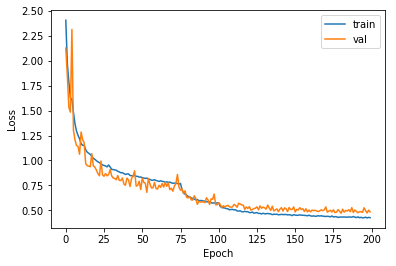

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

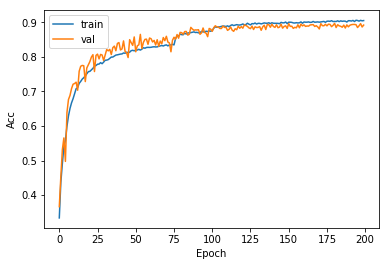

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [19]:
pred=model.predict(x_test[0].reshape(1,32,32,3))
print(pred)
print(pred.argmax())

[[5.4676761e-04 8.8149984e-04 6.1482529e-04 9.8012137e-01 2.3354427e-04
  1.6112758e-02 5.5357791e-04 8.6824657e-05 4.6877668e-04 3.8003191e-04]]
3


In [20]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.90      0.91      0.90      1000
     class 1       0.91      0.98      0.95      1000
     class 2       0.88      0.86      0.87      1000
     class 3       0.87      0.70      0.78      1000
     class 4       0.86      0.91      0.88      1000
     class 5       0.90      0.78      0.84      1000
     class 6       0.83      0.96      0.89      1000
     class 7       0.89      0.95      0.92      1000
     class 8       0.94      0.94      0.94      1000
     class 9       0.93      0.92      0.93      1000

   micro avg       0.89      0.89      0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [21]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    acc=np.trace(cm)/float(np.sum(cm))
    miss_class=1-acc
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(acc)
    print(miss_class)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[909  11  17   2   4   0   3   8  33  13]
 [  3 982   0   0   1   0   1   0   3  10]
 [ 31   1 858   7  33  14  39   9   1   7]
 [ 21  10  32 703  43  62  79  24  12  14]
 [  6   1  20   7 911   4  26  25   0   0]
 [  3   5  22  72  35 778  33  47   1   4]
 [  5   1  13   6  13   0 959   1   1   1]
 [  4   0   7   5  18   5   3 954   1   3]
 [ 18  12   4   0   5   0   5   2 939  15]
 [ 12  51   2   2   0   0   2   3   4 924]]
0.8917
0.10829999999999995


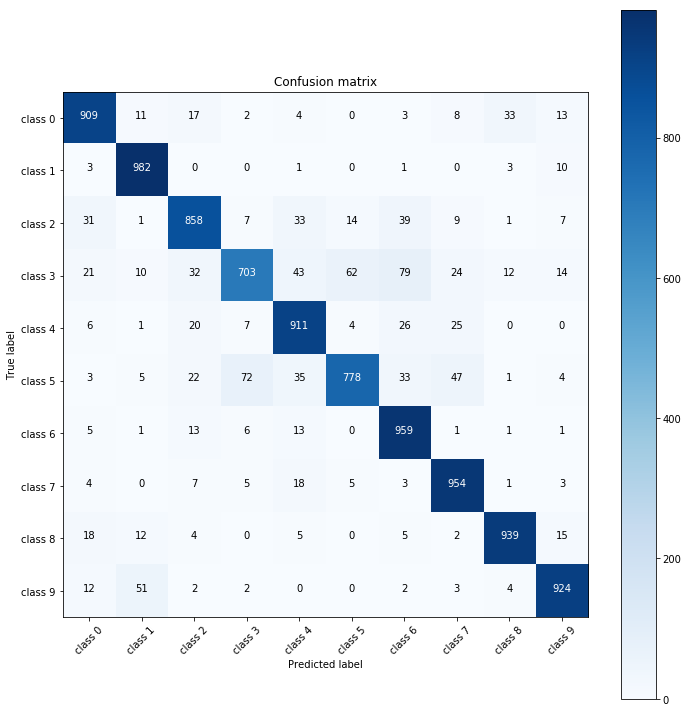

In [22]:
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')